# DTSA-5511 Introduction to Deep Learning - Final Project
## Analysis of NCAA men's basketball regular season and subsequent postseason tournament performance - methods using deep learning
### Step 1 - Gather data, determine the method of data collection and provenance of the data

For this final project I wanted to have some fun and at the same time put some skills I learned in this class to use. I found [a dataset on Kaggle](https://www.kaggle.com/competitions/march-machine-learning-mania-2023/data) that lists very detailed results of the NCAA men's basketball regular season and postseason games. To understand my project it might be necessary to have a basic understanding of how to the postseason tournament works. You can read about the tournament on [this Wikipedia page](https://en.wikipedia.org/wiki/2023_NCAA_Division_I_men%27s_basketball_tournament). The method of data collection is simply the records of each team over the regular season and NCAA tournament (if applicable.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# "gathering" the data:
fp = "C:/Users/bstrub/Documents/ml/5511_final/march-machine-learning-mania-2023/"
regseas = pd.read_csv(fp + "MRegularSeasonDetailedResults.csv") # import data from yearly regular seasons
tourney = pd.read_csv(fp + "MNCAATourneyCompactResults.csv") # import data from yearly tournaments
conf = pd.read_csv(fp + "MTeamConferences.csv") # import data about which team was in which conference by year
seeds = pd.read_csv(fp + "MNCAATourneySeeds.csv") # import data about which team was assigned to which seed
slots = pd.read_csv(fp + "MNCAATourneySlots.csv") # import data about which seed advanced to which round

print(regseas.head())
print(tourney.head())
print(conf.head())
print(seeds.head())

C:\Users\bstrub\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003      10     1104      68     1328      62    N      0    27    58   
1    2003      10     1272      70     1393      63    N      0    26    62   
2    2003      11     1266      73     1437      61    N      0    24    58   
3    2003      11     1296      56     1457      50    N      0    18    38   
4    2003      11     1400      77     1208      71    N      0    30    61   

   ...  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0  ...     10    16    22   10   22     8   18     9     2   20  
1  ...     24     9    20   20   25     7   12     8     6   16  
2  ...     26    14    23   31   22     9   12     2     5   23  
3  ...     22     8    15   17   20     9   19     4     3   23  
4  ...     16    17    27   21   15    12   10     7     1   14  

[5 rows x 34 columns]
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     12

### Step 2 - Identify a Deep Learning Problem

Armed with this data, the goal of my final project will be to use deep learning models with the purpose of predicting which teams will make the tournament itself - this is the **problem**. 

My initial guess is that the results of this project will be just "OK". I say this because there is a good amound of randomness that takes place in the NCAA regular season and tournament, with "underdog" teams frequently defeating the expected winners. This is what makes the NCAA tournament fun and famously unpredictable. What is really cool, is that at that time of creating this project, the regular season has yet to be finished and tournament seeds decided, thus naturally creating my own test set for the model.

I want to clarify my actions here in this project in regards to the instructions for the final project: While I am using data from a Kaggle competiton, the analysis will not be in relation to the goals of the competiton at all. I will **NOT** be replicating what is in the Kaggle kernel or other notebooks that can be found online. 

Here is how I will proceed:
1) Data cleaning and Exploratory Data Anlaysis (EDA): this will include cleaning, exploring the data, and using Principal Component Analysis to perform dimensionaly reduction

2) Perform deep learning modeling

3) Analysis, discussion and conclusion

### Step 3 - Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data
#### Inspect the data
Taking a look at the data as a whole, the initial size of the entire folder from Kaggle is 136 MB. To better strategize about my approach to modling this data, I want to understand the shape of some of the important features in the `regseas` table since this table contains all of the features that will be crucial in modeling the data. 

In [2]:
# Metrics as a whole
metric_name = ["Number of unique seasons",
               "First season",
               "Most recent season",
               "Number of unique teams",
               "Number of unique games"]
metric_value = [len(pd.unique(regseas['Season'])),
                min(regseas['Season']),
                max(regseas['Season']),
                len(pd.unique(regseas['WTeamID'].tolist() + regseas['LTeamID'].tolist())),
                regseas.shape[0]]
total_metric_table = pd.DataFrame({'Metric Name':metric_name,'Metric Value':metric_value})
display(total_metric_table)

print(pd.unique(regseas['Season']))

,Metric Name,Metric Value
0,Number of unique seasons,21
1,First season,2003
2,Most recent season,2023
3,Number of unique teams,368
4,Number of unique games,106834


[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019 2020 2021 2022 2023]



#### Describe the factors or components that make up the dataset.
`Describe the factors or components that make up the dataset (The "factors" here are called "features" in the machine learning term. These factors are often columns in the tabulated data). For each factor, use a box-plot, scatter plot, histogram, etc., to describe the data distribution as appropriate.`

The most important dataset out of the four that I loaded is the regular season (MRegularSeasonDetailedResults.csv) table. This is because my models will use the regualar season team performance to predict whether or not a given team will reach the ncaa tournament and out of the ones that do reach the tourney, how far they will go. Let's start by defining the factors in this data:

- Season - Season by year (example: 2015 is the 2014-2015 season, since the NCAA basketball season spans between years)
- DayNum - indicator for the day in the season that the game was played
- WTeamID - Team ID (winning team)
- WScore - number of points scored (by the winng team)
- LTeamID - Team ID (losing team)
- LScore - number of points scored (by the losing team)
- NumOT - number of overtimes the game went to
- WLoc - location of the match in relation to the winning team (home, away, neutral) 
- WFGM - field goals made (by the winning team)
- WFGA - field goals attempted (by the winning team)
- WFGM3 - three pointers made (by the winning team)
- WFGA3 - three pointers attempted (by the winning team)
- WFTM - free throws made (by the winning team)
- WFTA - free throws attempted (by the winning team)
- WOR - offensive rebounds (pulled by the winning team)
- WDR - defensive rebounds (pulled by the winning team)
- WAst - assists (by the winning team)
- WTO - turnovers committed (by the winning team)
- WStl - steals (accomplished by the winning team)
- WBlk - blocks (accomplished by the winning team)
- WPF - personal fouls committed (by the winning team)
- LFGM - field goals made (by the losing team)
- LFGA - field goals attempted (by the losing team)
- LFGM3 - three pointers made (by the losing team)
- LFGA3 - three pointers attempted (by the losing team)
- LFTM - free throws made (by the losing team)
- LFTA - free throws attempted (by the losing team)
- LOR - offensive rebounds (pulled by the losing team)
- LDR - defensive rebounds (pulled by the losing team)
- LAst - assists (by the losing team)
- LTO - turnovers committed (by the losing team)
- LStl - steals (accomplished by the losing team)
- LBlk - blocks (accomplished by the losing team)
- LPF - personal fouls committed (by the losing team)

The first thing that you will likely notice about this dataset is that the grain is one row per game played. This will make it difficult to analyze by team performance, so I would like to reshape the data so that it is one row per game per team.

In [3]:
########################################
# DATA CLEANING: RESHAPING THE REGULAR SEASON DATAFRAME

# create an ID for the game
regseas['GameId'] = np.arange(len(regseas))

# create a variable for margin of victory (or loss)
regseas['WGameMargin'] = regseas['WScore'] - regseas['LScore']
regseas['LGameMargin'] = regseas['LScore'] - regseas['WScore']

# create winners dataset
wregseas = regseas.copy()
wregseas = wregseas[['Season','GameId','WTeamID','WScore','NumOT','WFGM','WFGA','WFGM3',
                   'WFGA3','WFTM','WFTA','WOR','WDR','WAst','WTO','WStl','WBlk','WPF','WLoc',
                    'WGameMargin']] # select the columns that are 
                                    #relevant to the winners
wregseas['GameResult'] = 'win' # mark that the team won the game in question
wregseas = wregseas.rename(columns={'WTeamID':'TeamID','WScore':'PointsScored',
                                    'WFGM':'FGM','WFGA':'FGA','WFGM3':'FGM3','WFGA3':'FGA3','WFTM':'FTM',
                                    'WFTA':'FTA','WOR':'OFFR','WDR':'DEFR','WAst':'Ast','WTO':'TURNO',
                                    'WStl':'Stl','WBlk':'Blk','WPF':'PF', 'WLoc':'Loc',
                                    'WGameMargin':'GameMargin'}) # generalize column names


# create losers dataset
lregseas = regseas.copy()
lregseas = lregseas[['Season','GameId','LTeamID','LScore','WLoc','NumOT','LFGM','LFGA','LFGM3',
                   'LFGA3','LFTM','LFTA','LOR','LDR','LAst','LTO','LStl','LBlk','LPF',
                    'LGameMargin']] # select the columns that are 
                                    #relevant to the losers
locrecode = {'H':'A','A':'H','N':'N'} # we need to recode the location for the game, because the location of the winner is
                                        # the opposite for the loser, except in the case where the game is being played in 
                                        # a neutral location
lregseas = lregseas.assign(Loc = lregseas.WLoc.map(locrecode)) # do the recoding
lregseas = lregseas.drop('WLoc',axis = 1)
lregseas['GameResult'] = 'loss' # mark that the team won the game in question
lregseas = lregseas.rename(columns={'LTeamID':'TeamID','LScore':'PointsScored', 
                                   'LFGM':'FGM','LFGA':'FGA','LFGM3':'FGM3','LFGA3':'FGA3',
                                   'LFTM':'FTM','LFTA':'FTA','LOR':'OFFR','LDR':'DEFR','LAst':'Ast',
                                   'LTO':'TURNO','LStl':'Stl','LBlk':'Blk','LPF':'PF',
                                    'LGameMargin':'GameMargin'}) # generalize column names


# combine datasets
allregseas = pd.concat([wregseas,lregseas])
allregseas.sort_values(by=['Season', 'GameId','GameResult'], inplace = True) # make dataset chronological
allregseas.reset_index(drop = True, inplace = True) # reset row index

# merge in the league in which the team played in that season
allregseas = pd.merge(allregseas,conf,how = "left",on = ['Season','TeamID'])

print(allregseas)

        Season  GameId  TeamID  PointsScored  NumOT  FGM  FGA  FGM3  FGA3  \
0         2003       0    1328            62      0   22   53     2    10   
1         2003       0    1104            68      0   27   58     3    14   
2         2003       1    1393            63      0   24   67     6    24   
3         2003       1    1272            70      0   26   62     8    20   
4         2003       2    1437            61      0   22   73     3    26   
...        ...     ...     ...           ...    ...  ...  ...   ...   ...   
213663    2023  106831    1429            65      0   21   51     7    27   
213664    2023  106832    1386            63      0   21   56     8    28   
213665    2023  106832    1433            88      0   31   59    11    19   
213666    2023  106833    1462            63      0   23   51     8    23   
213667    2023  106833    1437            64      0   25   56     6    19   

        FTM  ...  DEFR  Ast  TURNO  Stl  Blk  PF  Loc  GameMargin GameResul

Now that our data is reshaped (the first step in cleaning data) let's examine some plots to see if any further cleaning is necessary:

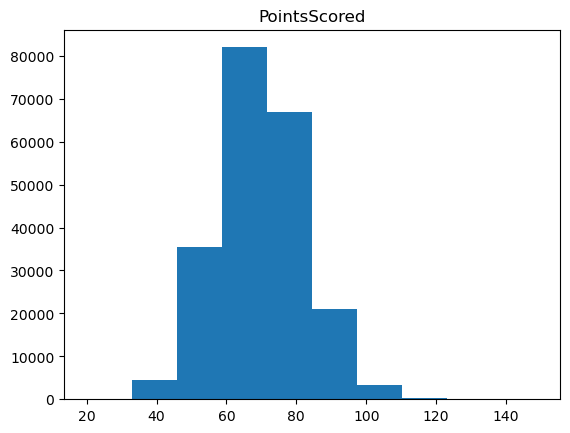

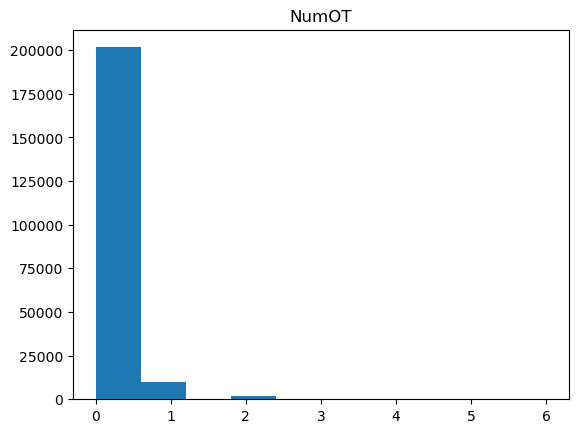

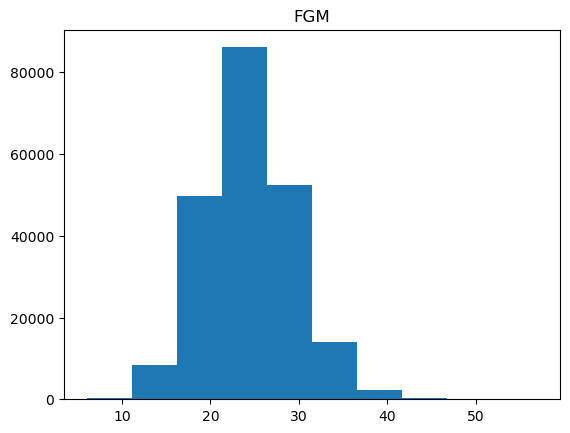

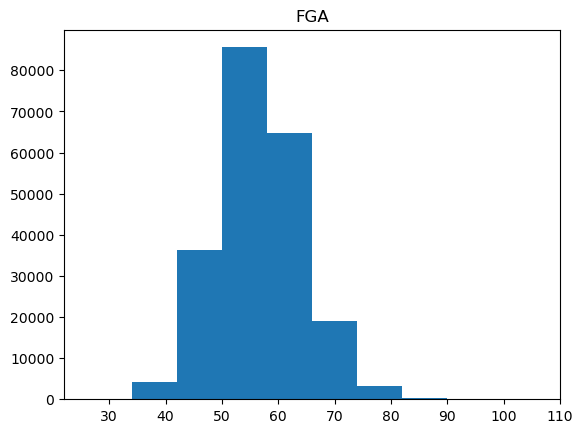

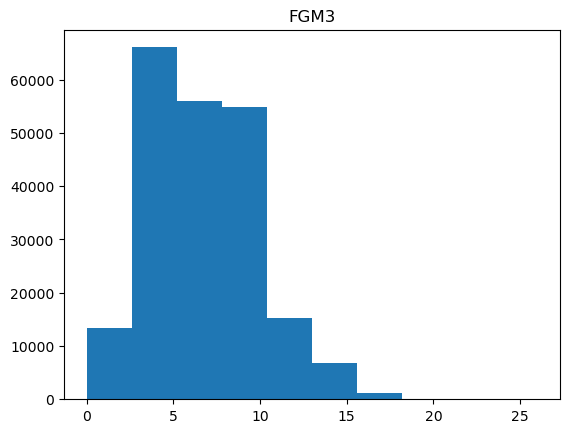

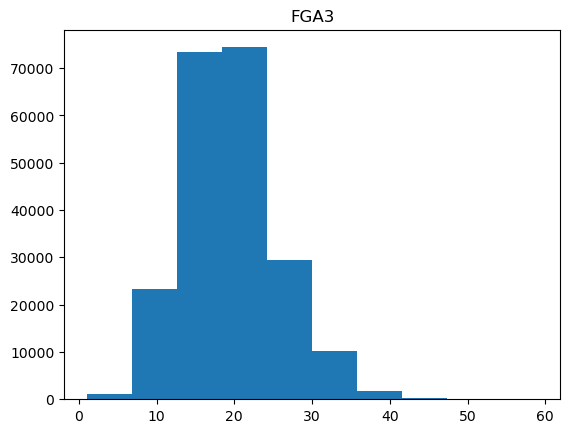

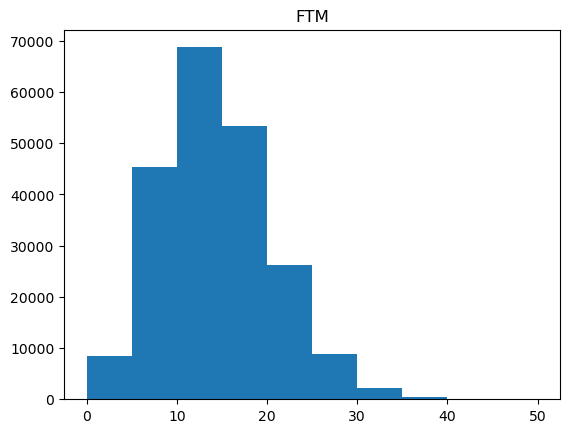

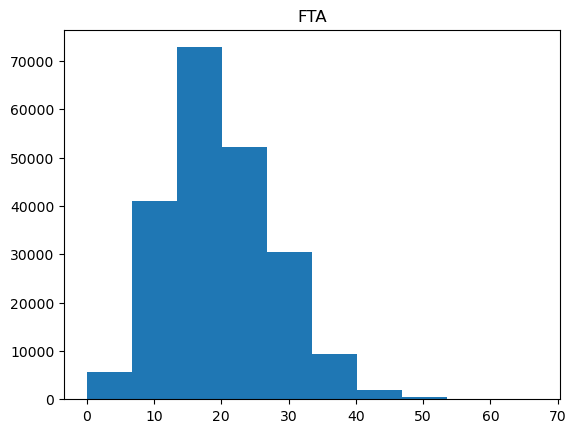

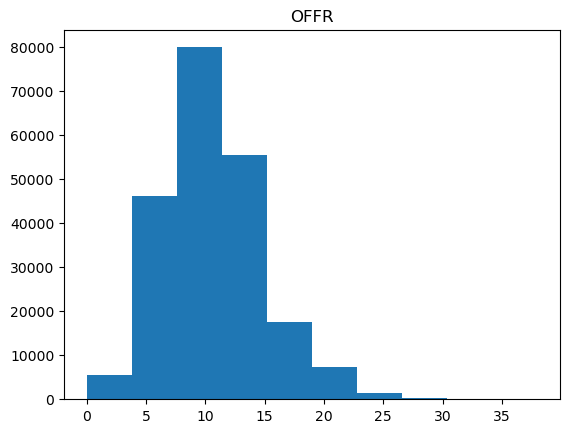

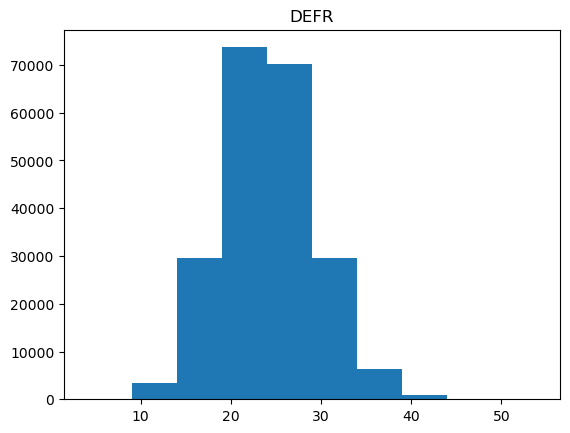

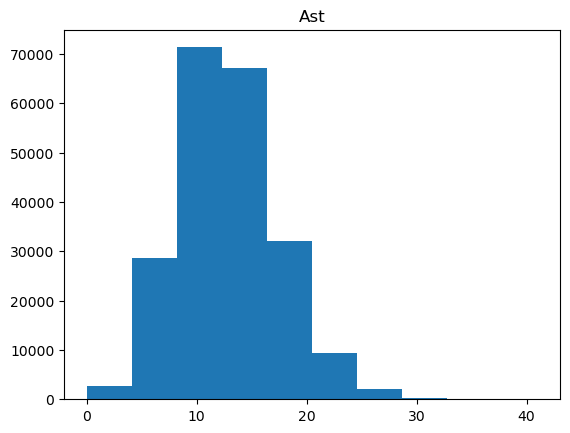

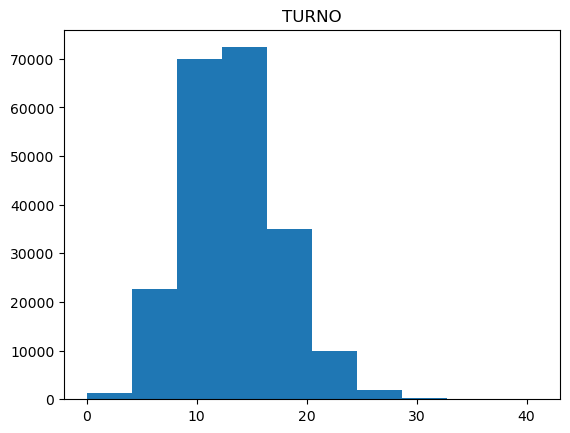

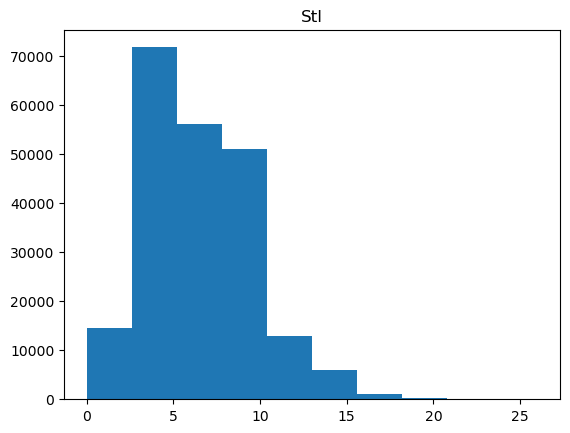

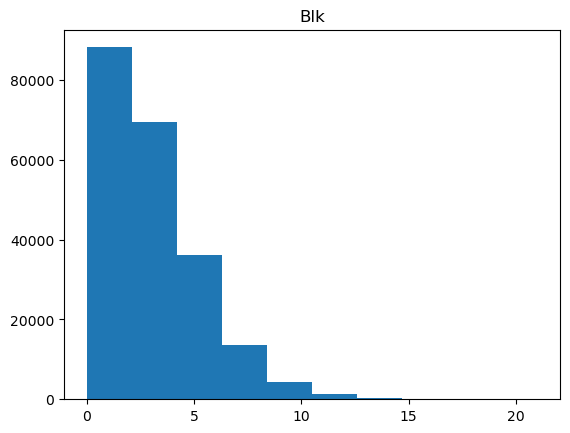

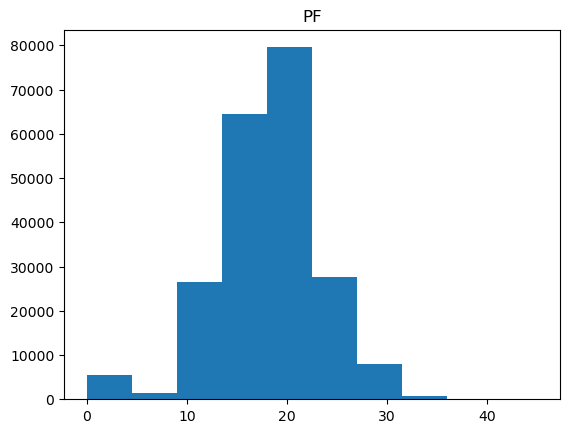

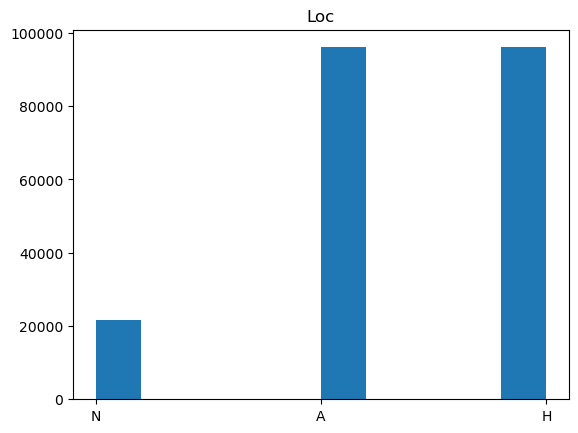

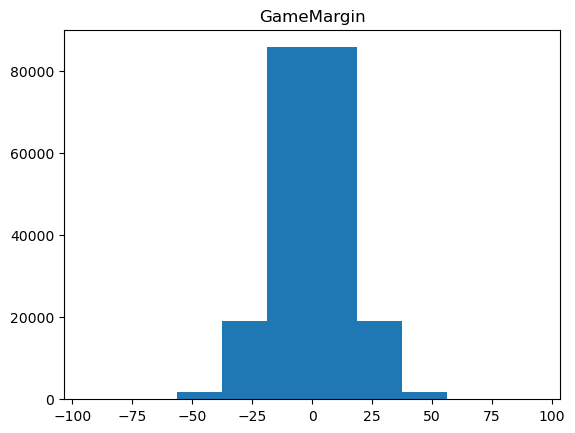

In [4]:
for c in ['PointsScored', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OFFR', 'DEFR', 'Ast', 'TURNO', 
          'Stl', 'Blk', 'PF', 'Loc','GameMargin']:
    plt.hist(allregseas[c])
    plt.title(c)
    plt.show()

One of the things that I find intersting about these histograms is that they come in a lot of different shapes. Maybe I didn't think hard enough before I selected this data, but I assumed in my head that all of the basketball statistics would have more or less the same shape. It's really interesting to see some appear to be positivley skewed like the FTM feature (free-throws made), some appear slightly negatively skewed like the PF feature (personal fouls), and apparently normal, like the DEFR feature (defensive rebounds.)

From these plots, I don't see anything that jumps out at me as needing to be cleaned. 

#### Describe correlations between different factors of the dataset and justify your assumption
`Describe correlations between different factors of the dataset and justify your assumption that they are correlated or not correlated. You may use numeric or qualitative/graphical analysis for this step.`

In order to understand the corrleation in a dataset, one should take a look at the coorelation matrix. Let's do that here.

In [5]:
########################################
# DATA VISUALIZATION: PLOT CORRELATION
corrplot = allregseas.copy()
corrplot = corrplot[['PointsScored', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OFFR', 
                     'DEFR', 'Ast', 'TURNO', 'Stl', 'Blk', 'PF', 'Loc', 'GameResult','GameMargin']] # delete columns that have 
                                                                                        # no value (the ID columns)
corr = corrplot.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision = 2)

,PointsScored,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OFFR,DEFR,Ast,TURNO,Stl,Blk,PF,GameMargin
PointsScored,1.00,0.18,0.86,0.39,0.48,0.19,0.44,0.39,0.09,0.29,0.61,-0.13,0.16,0.14,0.08,0.61
NumOT,0.18,1.00,0.14,0.22,0.06,0.09,0.13,0.14,0.09,0.15,0.05,0.06,0.04,0.05,0.12,-0.00
FGM,0.86,0.14,1.00,0.54,0.38,0.14,-0.03,-0.04,0.09,0.24,0.64,-0.16,0.16,0.13,-0.00,0.53
FGA,0.39,0.22,0.54,1.00,0.19,0.41,-0.15,-0.14,0.54,0.16,0.24,-0.23,0.19,0.08,0.09,0.03
FGM3,0.48,0.06,0.38,0.19,1.00,0.70,-0.11,-0.14,-0.10,0.05,0.48,-0.11,-0.01,-0.01,-0.03,0.28
FGA3,0.19,0.09,0.14,0.41,0.70,1.00,-0.18,-0.20,0.08,0.02,0.24,-0.15,0.02,-0.04,-0.01,0.00
FTM,0.44,0.13,-0.03,-0.15,-0.11,-0.18,1.00,0.93,0.08,0.19,-0.01,0.04,0.08,0.09,0.19,0.26
FTA,0.39,0.14,-0.04,-0.14,-0.14,-0.20,0.93,1.00,0.15,0.21,-0.02,0.06,0.11,0.10,0.22,0.22
OFFR,0.09,0.09,0.09,0.54,-0.10,0.08,0.08,0.15,1.00,0.04,-0.01,0.09,0.11,0.09,0.13,0.03
DEFR,0.29,0.15,0.24,0.16,0.05,0.02,0.19,0.21,0.04,1.00,0.20,0.12,-0.12,0.27,-0.02,0.46


Like the histograms from the previous EDA step, I find this plot to really interesting as well. Again, anyone who knows anything about basketball will tell you without looking at any correlation plots that field goals made (`FGM`) and the number of points a team scores (`PointsScored`) are going to be correlated. Having said that, it is enlightening to see this in statistical form. Looking at field goals attempted (`FGA`) and offensive rebounds (`OFFR`), something that is isn't necessarily intuitive is that field goals attempted is slightly correlated with the number of offensive rebounds a team gets. On the flip side, something that I personally think **would** be correlated is offensive rebounds (`OFFR`) and defensive rebounds (`DFFR`), that is to say, if a team is good at deffensive rebounds they would also be good offensive rebounds. However, this chart shows with a correlation value of .04, that this is not the case.

#### Determine if any data needs to be transformed.
`Determine if any data needs to be transformed. For example, if you're planning on using an SVM method for prediction, you may need to normalize or scale the data if there is a considerable difference in the range of the data.`

In order to model the results by season, we need to summarize the performace of each of the each team over the season in question. In order to do this, however, lets make sure each team in each league/season played the same amount of games:

In [6]:
testnumgames = allregseas[['Season','TeamID','ConfAbbrev','GameId']].groupby(['Season','ConfAbbrev','TeamID']).count()
testnumgames.columns = ['ngames']
testnumgames.reset_index(inplace = True)
print(testnumgames)
print(testnumgames[(testnumgames['Season'] == 2003) & (testnumgames['ConfAbbrev'] == 'a_sun')])# change this to any conference/
                                                                                                # year

      Season ConfAbbrev  TeamID  ngames
0       2003      a_sun    1125      28
1       2003      a_sun    1144      26
2       2003      a_sun    1194      27
3       2003      a_sun    1205      28
4       2003      a_sun    1209      28
...      ...        ...     ...     ...
7250    2023        wcc    1339      27
7251    2023        wcc    1360      26
7252    2023        wcc    1362      28
7253    2023        wcc    1365      28
7254    2023        wcc    1388      28

[7255 rows x 4 columns]
    Season ConfAbbrev  TeamID  ngames
0     2003      a_sun    1125      28
1     2003      a_sun    1144      26
2     2003      a_sun    1194      27
3     2003      a_sun    1205      28
4     2003      a_sun    1209      28
5     2003      a_sun    1239      28
6     2003      a_sun    1240      29
7     2003      a_sun    1273      28
8     2003      a_sun    1359      27
9     2003      a_sun    1391      26
10    2003      a_sun    1407      30
11    2003      a_sun    1416      31


As we can see from the above result, some teams played different numbers of games than the others in their conferences, putting them at a statisical disadvantage. Thus I believe we should **interpolate** the games that they didn't play.

*Note: a college basketball fan would point out that the reason many of these teams played fewer season games is because they weren't good enough to progress in their conference tournament, in which case putting them at a statistical disadvantage because they played fewer games is a good thing. However, for the purposes of this final project and displaying the concept of interpolation, I'm going to continute down the interpolation path.*

**Forewarning: the interpolation code takes approximately 15 minutes to run**

In [7]:
########################################
# EDA AND DATA CLEANING: INTERPOLATING DATA
startTime = time.time()

def interp_season(s, c, t, g, tempdf):
    # input: the season, the conference, the team, and the number of additional games to interpolate for
    # return: a pandas dataframe where the number of rows reflects the number of games to interpolate for
    
    df = tempdf.copy()
    df = df[(df['Season'] == s) & (df['ConfAbbrev'] == c) & (df['TeamID'] == t)]

    # interpolate numerics
    aggnum = df[['PointsScored', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OFFR', 'DEFR', 'Ast', 'TURNO', 'Stl', 
                 'Blk', 'PF', 'GameMargin']].agg(['mean'])
    aggnum = aggnum.reset_index(drop=True)
    if g > 1:
        temp = pd.DataFrame(aggnum.copy())
        for i in range(1,g):
            aggnum = pd.concat([temp,aggnum])
    aggnum = aggnum.reset_index(drop=True)

    # adhoc interpolate non-numerics
    aggstr = pd.DataFrame({"Season":[s],
            "GameId":[-1],
            "Loc":df['Loc'].mode().iloc[0],
            "GameResult":df['GameResult'].mode().iloc[0],
            "ConfAbbrev":[c]})
    if g > 1:
        temp = pd.DataFrame(aggstr.copy())
        for i in range(1,g):
            aggstr = pd.concat([temp,aggstr])
    aggstr = aggstr.reset_index(drop=True)

        
    # now create the data frame to be returned
    returnme = aggstr.join(aggnum)
    returnme['TeamID'] = t
    returnme = returnme[['Season', 'GameId', 'TeamID', 'PointsScored', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 
                         'OFFR', 'DEFR', 'Ast', 'TURNO', 'Stl', 'Blk', 'PF', 'Loc', 'GameMargin', 'GameResult', 'ConfAbbrev']]

    return returnme
    
    

allregseasinterp = allregseas.copy()

# get the maximum number of games any team from a given conference/year played during the season
getnumgames = testnumgames.groupby(['Season','ConfAbbrev']).agg({'ngames':['max']})
getnumgames.columns = ['maxngames']
getnumgames = getnumgames.reset_index()

# loop through each season/conference/team and interpolate (if necessary)
for s in testnumgames['Season'].unique():
    for c in testnumgames[(testnumgames['Season'] == s)]['ConfAbbrev'].unique():
        l = getnumgames[(getnumgames['Season'] == s) & (getnumgames['ConfAbbrev'] == c)]['maxngames'].iloc[0] # maximum number 
                                                                                                        # of games any team from
                                                                                                        # the conference played
                                                                                                        # in a season
        for t in testnumgames[(testnumgames['Season'] == s) & (testnumgames['ConfAbbrev'] == c)]['TeamID']:
            r = testnumgames[(testnumgames['Season'] == s) & (testnumgames['ConfAbbrev'] == c) 
                             & (testnumgames['TeamID'] == t)]['ngames'].iloc[0] # get the number of games a team played in the 
                                                                                # season
            g = l - r # count how many games the team is missing
            if (g != 0): # if statement to root out teams that don't need interpolation
                bindme = interp_season(s, c, t, g, allregseasinterp) # call interpolation function
                allregseasinterp = pd.concat([allregseasinterp,bindme])
                
                
endTime = time.time()
print(endTime - startTime)
print(allregseasinterp)

976.2392370700836
    Season  GameId  TeamID  PointsScored     NumOT        FGM        FGA  \
0     2003       0    1328     62.000000  0.000000  22.000000  53.000000   
1     2003       0    1104     68.000000  0.000000  27.000000  58.000000   
2     2003       1    1393     63.000000  0.000000  24.000000  67.000000   
3     2003       1    1272     70.000000  0.000000  26.000000  62.000000   
4     2003       2    1437     61.000000  0.000000  22.000000  73.000000   
..     ...     ...     ...           ...       ...        ...        ...   
0     2023      -1    1337     77.307692  0.153846  28.500000  62.769231   
1     2023      -1    1337     77.307692  0.153846  28.500000  62.769231   
0     2023      -1    1339     75.851852  0.074074  24.814815  54.851852   
0     2023      -1    1360     77.038462  0.076923  27.269231  60.538462   
1     2023      -1    1360     77.038462  0.076923  27.269231  60.538462   

        FGM3       FGA3        FTM  ...       DEFR        Ast      TU

Alright, that took a long time. Lets see if the interpolation function was successful at plugging the gaps in the data.

In [8]:
testnumgames = allregseasinterp[['Season','TeamID','ConfAbbrev','GameId']].groupby(['Season','ConfAbbrev','TeamID']).count()
testnumgames.columns = ['ngames']
testnumgames.reset_index(inplace = True)
print(testnumgames)
print(testnumgames[(testnumgames['Season'] == 2023) & (testnumgames['ConfAbbrev'] == 'wcc')]) # change this to any conference/
                                                                                                # year

      Season ConfAbbrev  TeamID  ngames
0       2003      a_sun    1125      31
1       2003      a_sun    1144      31
2       2003      a_sun    1194      31
3       2003      a_sun    1205      31
4       2003      a_sun    1209      31
...      ...        ...     ...     ...
7250    2023        wcc    1339      28
7251    2023        wcc    1360      28
7252    2023        wcc    1362      28
7253    2023        wcc    1365      28
7254    2023        wcc    1388      28

[7255 rows x 4 columns]
      Season ConfAbbrev  TeamID  ngames
7245    2023        wcc    1140      28
7246    2023        wcc    1211      28
7247    2023        wcc    1258      28
7248    2023        wcc    1334      28
7249    2023        wcc    1337      28
7250    2023        wcc    1339      28
7251    2023        wcc    1360      28
7252    2023        wcc    1362      28
7253    2023        wcc    1365      28
7254    2023        wcc    1388      28


#### Using your hypothesis, indicate if it's likely that you should transform data
`Using your hypothesis, indicate if it's likely that you should transform data, such as using a log transform or other transformation of the dataset.`

Based on the number of features in the data, I want to run a Primary Component Analysis transformation. Keeping in mind the results of the correlation matrix above, I have decided that for my project, I want to run models on four different datasets:

1. The interpolated data
2. The interpolated data with PCA transformation
3. The regular data with highly correlated columns removed
4. The regular data with highly correlated columns with PCA transformation

Why run just one data set when we have the programming power to programatically run multiple? We've already computed dataset #1: the interpolated data. All that remains is #3 (a trivial case of removing columns based on the correlation matrix), #2 and #4, the PCA datasets.

For #3 and #4, I will drop columns based on their correlation values and knowledge of the game of basketball. For example, a good free-throw shooting team will make around 90% of their free throws. Thus we should eliminate `FTA` in favor of `FTM` since because we know that they will be highly correlated.

I will also collapse the data using the mean of the column so that we have 1 line per season/team for modeling purposes.

In [9]:
# create reponse column
seeds['MadeTourney'] = 1
seedsmt = seeds[['Season','TeamID','MadeTourney']].drop_duplicates(keep='first')


## Create dataset 1
allregseasinterpf = allregseasinterp[allregseasinterp['Season'] != 2023] # 2023 season is not complete yet so drop these
allregseasinterpf = allregseasinterpf.drop(['GameId','Loc','GameResult','ConfAbbrev'],axis = 1) 
allregseasinterpf = allregseasinterpf.groupby(['Season','TeamID']).mean()
allregseasinterpf.reset_index(inplace = True)
allregseasinterpf = allregseasinterpf.drop_duplicates(keep='first')

## Create dataset 2
# run PCA
# remove cols unrelated to to PCA and future modeling
allregseasinterppcaf = allregseasinterpf.drop(['Season','TeamID'],axis = 1) 
min_var_explained = 0.98
pca = PCA(n_components = min_var_explained, svd_solver = "full")
allregseasinterppcaf = pca.fit_transform(allregseasinterppcaf)

## Create dataset 3
# remove features
allregseascorf = allregseas[allregseas['Season'] != 2023]
allregseascorf  = allregseascorf.drop(['GameId','Loc','GameResult','ConfAbbrev'],axis = 1) 
allregseascorf  = allregseascorf.groupby(['Season','TeamID']).mean()
allregseascorf.reset_index(inplace = True)
allregseascorf  = allregseascorf.drop_duplicates(keep='first')
allregseascorf = allregseascorf.drop(['PointsScored','GameMargin','FGA','FTA','FGA3'],axis = 1) # drop correlated values 

# Create dataset 4
# run PCA
# remove cols unrelated to to PCA and future modeling
allregseascorpcaf = allregseascorf.drop(['Season','TeamID'],axis = 1)
min_var_explained = 0.98
pca = PCA(n_components = min_var_explained, svd_solver = "full")
allregseascorpcaf = pca.fit_transform(allregseascorpcaf)


# Create labels for dataset 1 and 2
allregseasinterpf = pd.merge(allregseasinterpf,seedsmt, how = 'left', on = ['Season','TeamID'])
allregseasinterpf['MadeTourney'] = allregseasinterpf['MadeTourney'].fillna(0) # mark teams that did not make the tourney
allregseasinterpflabs = allregseasinterpf['MadeTourney'].tolist()
allregseasinterpf = allregseasinterpf.drop(['MadeTourney'],axis = 1)

# Create labels for dataset 3 and 4
allregseascorf = pd.merge(allregseascorf,seedsmt, how = 'left', on = ['Season','TeamID'])
allregseascorf['MadeTourney'] = allregseascorf['MadeTourney'].fillna(0) # mark teams that did not make the tourney
allregseascorflabs = allregseascorf['MadeTourney'].tolist()
allregseascorf = allregseascorf.drop(['MadeTourney'],axis = 1)


print(allregseasinterpf.shape)
print(allregseasinterppcaf.shape)
print(allregseascorf.shape)
print(allregseascorpcaf.shape)

(6892, 18)
(6892, 9)
(6892, 13)
(6892, 9)


#### Determine if your data has outliers or needs to be cleaned in any way
`You should determine if your data has outliers or needs to be cleaned in any way. Are there missing data values for specific factors? How will you handle the data cleaning? Will you discard, interpolate or otherwise substitute data values?`

At this point, we have already discarded, interpolated and substituted values based on their coorrelation to other features and based on our knowledge of the game of basketball. However, we do need to collapse the data so that we have 1 row per game for modelling purposes. 

#### If you believe that specific factors will be more important than others in your analysis
`If you believe that specific factors will be more important than others in your analysis, you should mention which and why. You will use this to confirm your intuitions in your final write-up.`

I beleive that the `FGM` feature will play the largest role in the analysis. This is because field goals made is the primary method of point scoring in basketball and determining the outcome of the match. While here and there mediocre teams may make a lot of field goals, over the course of the season the power of the offense should regress to a mean with the best teams making the most field goals. In addition, I beleive defensive rebounds (`DEFR`) may also play a large role. This is because this is a metric of a teams ability to create possesion of a opponents missed shot. It is a indicator of defensive ability.

### Step 4 - Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions 

As a refresher, we want to predict which teams will reach the NCAA tournament based on their regular season results. To start off, let's create a fully connected model using the simplest data that we have, the regular data with the highly correlated columns removed.

#### Model 1

In [44]:
## Model 1 code here
X = np.array(allregseascorf)
y = np.array(allregseascorflabs)

model = Sequential()
model.add(Dense(10, input_shape=(13,), activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=10, batch_size=10)

Epoch 1/10
690/690 [==============================] - 3s 2ms/step - loss: 1.4294 - accuracy: 0.7430
Epoch 2/10
690/690 [==============================] - 2s 2ms/step - loss: 0.5180 - accuracy: 0.7972
Epoch 3/10
690/690 [==============================] - 2s 2ms/step - loss: 0.4980 - accuracy: 0.8056
Epoch 4/10
690/690 [==============================] - 2s 2ms/step - loss: 0.4768 - accuracy: 0.8057
Epoch 5/10
690/690 [==============================] - 2s 2ms/step - loss: 0.4701 - accuracy: 0.8077
Epoch 6/10
690/690 [==============================] - 2s 2ms/step - loss: 0.4484 - accuracy: 0.8121
Epoch 7/10
690/690 [==============================] - 1s 2ms/step - loss: 0.4486 - accuracy: 0.8149
Epoch 8/10
690/690 [==============================] - 2s 2ms/step - loss: 0.4503 - accuracy: 0.8134
Epoch 9/10
690/690 [==============================] - 2s 2ms/step - loss: 0.4380 - accuracy: 0.8172
Epoch 10/10
690/690 [==============================] - 2s 2ms/step - loss: 0.4629 - accuracy: 0.8124

In [45]:
_, accuracy = model.evaluate(X, y)

216/216 [==============================] - 1s 2ms/step - loss: 0.3688 - accuracy: 0.8365


83.1% isn't too bad for a first pass, especially considering how random college basketball is. A few things to note: we only ran 10 epochs as a trial run. Since the accuracy kept increasing until the final Epoch, I would bet that if we increased the number of epochs we will get more accuate results. Lets try that now:

`hyperparameter optimization`
    
#### Model 2

In [46]:
# model 2 code here
model = Sequential()
model.add(Dense(10, input_shape=(13,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=30, batch_size=10)

Epoch 1/30
690/690 [==============================] - 3s 2ms/step - loss: 7.3169 - accuracy: 0.6828
Epoch 2/30
690/690 [==============================] - 2s 2ms/step - loss: 0.6262 - accuracy: 0.7636
Epoch 3/30
690/690 [==============================] - 2s 2ms/step - loss: 0.5310 - accuracy: 0.8038
Epoch 4/30
690/690 [==============================] - 2s 2ms/step - loss: 0.5152 - accuracy: 0.8028
Epoch 5/30
690/690 [==============================] - 2s 2ms/step - loss: 0.4793 - accuracy: 0.8130
Epoch 6/30
690/690 [==============================] - 2s 2ms/step - loss: 0.4606 - accuracy: 0.8134
Epoch 7/30
690/690 [==============================] - 2s 2ms/step - loss: 0.4477 - accuracy: 0.8147
Epoch 8/30
690/690 [==============================] - 2s 2ms/step - loss: 0.4297 - accuracy: 0.8221
Epoch 9/30
690/690 [==============================] - 2s 2ms/step - loss: 0.4443 - accuracy: 0.8157
Epoch 10/30
690/690 [==============================] - 2s 2ms/step - loss: 0.4204 - accuracy: 0.8237

In [47]:
_, accuracy = model.evaluate(X, y)

216/216 [==============================] - 1s 2ms/step - loss: 0.3698 - accuracy: 0.8436


`compare multiple models`

We seem to be topping out at about 83.5% accuracy around the 20th epoch, so I'll conculde that 20 epochs is sufficient for future models. Lets try another model but with the the PCA transformation:

#### Model 3

In [51]:
## Model 3 code here
X = np.array(allregseascorpcaf)
y = np.array(allregseascorflabs)

model = Sequential()
model.add(Dense(10, input_shape=(9,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=20, batch_size=10)

Epoch 1/20
690/690 [==============================] - 3s 2ms/step - loss: 0.5126 - accuracy: 0.7512
Epoch 2/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3564 - accuracy: 0.8497
Epoch 3/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3446 - accuracy: 0.8533
Epoch 4/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3401 - accuracy: 0.8556
Epoch 5/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3372 - accuracy: 0.8546
Epoch 6/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3353 - accuracy: 0.8559
Epoch 7/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3344 - accuracy: 0.8555
Epoch 8/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3334 - accuracy: 0.8564
Epoch 9/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3325 - accuracy: 0.8571
Epoch 10/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3321 - accuracy: 0.8552

In [52]:
_, accuracy = model.evaluate(X, y)

216/216 [==============================] - 1s 2ms/step - loss: 0.3269 - accuracy: 0.8613


86% is great! Let's see if we can further improve by adding an additional fully connected layer:

#### Model 4

In [56]:
# model 4 code here
X = np.array(allregseascorpcaf)
y = np.array(allregseascorflabs)

model = Sequential()
model.add(Dense(10, input_shape=(9,), activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=20, batch_size=10)

Epoch 1/20
690/690 [==============================] - 3s 2ms/step - loss: 0.4780 - accuracy: 0.7655
Epoch 2/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3592 - accuracy: 0.8463
Epoch 3/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3468 - accuracy: 0.8519
Epoch 4/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3421 - accuracy: 0.8519
Epoch 5/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3394 - accuracy: 0.8520
Epoch 6/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3367 - accuracy: 0.8535
Epoch 7/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3347 - accuracy: 0.8530
Epoch 8/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3336 - accuracy: 0.8559
Epoch 9/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3320 - accuracy: 0.8584
Epoch 10/20
690/690 [==============================] - 2s 2ms/step - loss: 0.3313 - accuracy: 0.8574

In [57]:
_, accuracy = model.evaluate(X, y)

216/216 [==============================] - 1s 2ms/step - loss: 0.3238 - accuracy: 0.8635


It appears that adding a fully connected layer wasn't worth the trouble with limited improvement to the accuracy of the result.

##### Analysis and conclusion

Any college basketball fan would tell you that prediciton with 86% accuacy is great. Although this isn't the most difficult challenge, predicting who will get into the tournament as opposed to prediciting who will win the tournament, I think this is a great starting point and shows potential for this topic to be expanded beyond the methods described in this class.

I think there are ways to continue to improve deep learning in college basketball in regards to this project. I think the first, in true data science fashion, is to combine more subject matter expertise to figure out which statistics are relevant and to create a network that makes sense to combine those statistics. Second, more complex models and functions would likely improve the result and create more accurate final numbers.

In sum, we used multiple deep learning models and hyperameter optimization to examine statistics about the NCAA men's college basketball season. We also looked at limitations and cautions specific models have and proposed solutions. Thank you for taking the time to review my project, I appreciate it!

### Bibliography
[Repository for this project is here.](https://github.com/brst2400/DTSA5511finalproject/)

[kaggle data set](https://www.kaggle.com/competitions/march-machine-learning-mania-2023/data)
